<a href="https://colab.research.google.com/github/respect5716/Deep-Learning-Paper-Implementation/blob/master/01_General/Batch%20Noramlization%20_%20Accelerating%20Deep%20Network%20Training%20by%20Reducing%20Internal%20Covariate%20Shift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Batch Noramlization _ Accelerating Deep Network Training by Reducing Internal Covariate Shift

## 0. Paper

### Info
* TItle : Batch Noramlization _ Accelerating Deep Network Training by Reducing Internal Covariate Shift
* Author : Sergey Ioffe, Christian Szegedy
* Publication : ICML 2015

### Summary
* mini-batch를 normalize함으로써 layer간의 internal covariate shift를 감소시킴
* 학습 속도가 빨라지고 regularization 역할도 가능

### Differences
* ##

## 1. Env

In [1]:
# Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

In [3]:
# GPU Setting
!nvidia-smi

print(f'tensorflow version : {tf.__version__}')
print(f'available GPU list : {tf.config.list_physical_devices("GPU")}')

Thu May 28 23:46:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# Hyperparameters
CONFIG = {
    'base_dir' : '/content/drive/Shared drives/Yoon/Project/Doing/Deep Learning Paper Implementation',
    'batch_size' : 128,
    'epoch_size' : 10
}

## 2. Data

In [0]:
data_path = os.path.join(CONFIG['base_dir'], 'data/mnist')

In [0]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data(data_path)

## 3. Model

In [0]:
class BatchNormLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(BatchNormLayer, self).__init__()
        self.momentum = 0.95

    def build(self, input_shape):
        self.gamma = self.add_weight(shape=input_shape[1:], initializer=tf.constant_initializer(1.), name='gamma')
        self.beta = self.add_weight(shape=input_shape[1:], initializer=tf.constant_initializer(0.), name='beta')
        self.moving_mu = self.add_weight(shape=input_shape[1:], initializer=tf.constant_initializer(0.), trainable=False, name='moving mu')
        self.moving_std = self.add_weight(shape=input_shape[1:], initializer=tf.constant_initializer(1.), trainable=False, name='moving_std')

    
    def call(self, x, training=None):
        if training:
            m = x.shape[0]
            if not m:
                m = 2
                
            mu = tf.math.reduce_mean(x, axis=0)
            std = (m / (m-1)) * tf.math.reduce_std(x, axis=0)
            self.moving_mu.assign(tf.add(self.momentum*self.moving_mu, (1-self.momentum)*mu))
            self.moving_std.assign(tf.add(self.momentum*self.moving_std,  (1-self.momentum)*std))        
        else:
            mu = self.moving_mu
            std = self.moving_std

        x = (x - mu) / tf.math.sqrt(tf.square(std) + 1e-5)
        x = self.gamma * x + self.beta
        return x

In [0]:
class Network(tf.keras.Model):
    def __init__(self):
        super(Network, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(100, activation='linear')
        self.dense2 = tf.keras.layers.Dense(100, activation='linear')
        self.dense3 = tf.keras.layers.Dense(100, activation='linear')
        self.output_layer = tf.keras.layers.Dense(10, activation='softmax')
        self.relu = tf.keras.layers.ReLU()

    def call(self, x ,training):
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.relu(x)
        x = self.dense2(x)
        x = self.relu(x)
        x = self.dense3(x)
        x = self.relu(x)
        x = self.output_layer(x)
        return x


class BatchNormNetwork(tf.keras.Model):
    def __init__(self):
        super(BatchNormNetwork, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(100, activation='linear')
        self.bn1 = BatchNormLayer()
        self.dense2 = tf.keras.layers.Dense(100, activation='linear')
        self.bn2 = BatchNormLayer()
        self.dense3 = tf.keras.layers.Dense(100, activation='linear')
        self.bn3 = BatchNormLayer()
        self.output_layer = tf.keras.layers.Dense(10, activation='softmax')
        self.relu = tf.keras.layers.ReLU()

    def call(self, x ,training):
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.bn1(x, training)
        x = self.relu(x)
        x = self.dense2(x)
        x = self.bn2(x, training)
        x = self.relu(x)
        x = self.dense3(x)
        x = self.bn3(x, training)
        x = self.relu(x)
        x = self.output_layer(x)
        return x

In [0]:
network = Network()
network.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['acc']
)

In [0]:
batchnorm_network = BatchNormNetwork()
batchnorm_network.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['acc']
)

## 4. Train

In [328]:
hist = network.fit(
    train_x, train_y,
    batch_size = CONFIG['batch_size'],
    epochs = CONFIG['epoch_size']
)

Epoch 1/10
469/469 [==============================] - 1s 2ms/step - loss: 1.9072 - acc: 0.8381
Epoch 2/10
469/469 [==============================] - 1s 2ms/step - loss: 0.3656 - acc: 0.9175
Epoch 3/10
469/469 [==============================] - 1s 2ms/step - loss: 0.2312 - acc: 0.9416
Epoch 4/10
469/469 [==============================] - 1s 2ms/step - loss: 0.1776 - acc: 0.9523
Epoch 5/10
469/469 [==============================] - 1s 2ms/step - loss: 0.1431 - acc: 0.9610
Epoch 6/10
469/469 [==============================] - 1s 2ms/step - loss: 0.1235 - acc: 0.9653
Epoch 7/10
469/469 [==============================] - 1s 2ms/step - loss: 0.1086 - acc: 0.9700
Epoch 8/10
469/469 [==============================] - 1s 2ms/step - loss: 0.1047 - acc: 0.9710
Epoch 9/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0949 - acc: 0.9734
Epoch 10/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0796 - acc: 0.9765


In [341]:
batchnorm_hist = batchnorm_network.fit(
    train_x, train_y,
    batch_size = CONFIG['batch_size'],
    epochs = CONFIG['epoch_size']
)

Epoch 1/10
469/469 [==============================] - 2s 5ms/step - loss: 0.3210 - acc: 0.9199
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1009 - acc: 0.9696
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0670 - acc: 0.9797
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0507 - acc: 0.9840
Epoch 5/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0386 - acc: 0.9881
Epoch 6/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0312 - acc: 0.9901
Epoch 7/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0255 - acc: 0.9921
Epoch 8/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0216 - acc: 0.9927
Epoch 9/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0201 - acc: 0.9934
Epoch 10/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0177 - acc: 0.9943


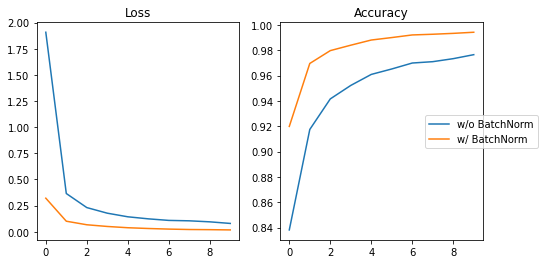

In [342]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

ax[0].plot(hist.history['loss'])
ax[0].plot(batchnorm_hist.history['loss'])
ax[0].set_title('Loss')

ax[1].plot(hist.history['acc'])
ax[1].plot(batchnorm_hist.history['acc'])
ax[1].set_title('Accuracy')

fig.legend(['w/o BatchNorm', 'w/ BatchNorm'], loc='right')
plt.show()

## 5. Test

In [313]:
loss, acc = network.evaluate(test_x, test_y, batch_size=CONFIG['batch_size'])

79/79 [==============================] - 0s 2ms/step - loss: 0.1489 - acc: 0.9715


In [343]:
batchnorm_loss, batchnorm_acc = batchnorm_network.evaluate(test_x, test_y, batch_size=CONFIG['batch_size'])

79/79 [==============================] - 0s 2ms/step - loss: 0.0773 - acc: 0.9787
